In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [34]:
gold = pd.read_csv('ouro2.csv', index_col='Data', parse_dates=['Data'], infer_datetime_format=True, dayfirst=True)
#gold = pd.read_csv('ouro2.csv')
#gold.columns = ['data', 'today_price']
gold.columns = ['today_price']
#gold['data'] = pd.to_datetime(gold.data, dayfirst=True)

# inverte dataframe para poder fazer as médias móveis com os valores corretos
gold = gold.reindex(index=gold.index[::-1])


#gold['last_week_price'] = gold.today_price.shift(1)
#filtro = np.where(gold['today_price'] > gold['last_week_price'], 1, 0)
#gold['target_subida'] = filtro
#gold['next_week_price'] = gold.today_price.shift(-1)
#gold['delta1'] = gold.today_price - gold.last_week_price
#gold['delta2'] = gold.next_week_price - gold.today_price
#gold['m3'] = gold.today_price.rolling(window=3).mean()
#gold.dropna(inplace=True)
gold.head(20)

,today_price
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-07-02,283.2
2000-07-09,281.1
2000-07-16,280.1
2000-07-23,277.7
2000-07-30,272.6
2000-08-06,275.1
2000-08-13,276.8


In [36]:
gold.tail(20)

,today_price
Data,
2021-01-31,1817.8
2021-02-07,1828.1
2021-02-14,1782.2
2021-02-21,1734.0
2021-02-28,1703.8
2021-03-07,1724.3
2021-03-14,1745.8
2021-03-21,1736.5
2021-03-28,1730.3


### Normal series

<AxesSubplot:xlabel='today_price', ylabel='Count'>

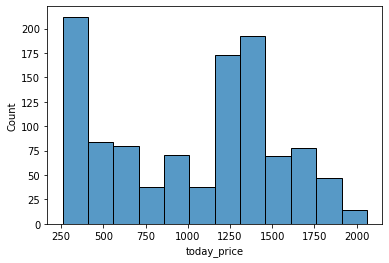

In [37]:
sns.histplot(gold.today_price)

<AxesSubplot:xlabel='Data', ylabel='today_price'>

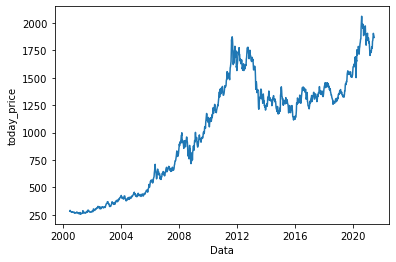

In [38]:
#print timeline graph
sns.lineplot(x=gold.index, y=gold.today_price)
#sns.lineplot(x=gold.data,y=gold.m7)
#sns.lineplot(x=gold.data,y=gold.m14)
#sns.lineplot(x=gold.data,y=gold.m21)

### Definindo função para criação do DataFrame com janela deslizante de dados

In [39]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
    # input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Função de plot

In [58]:
def plot_graph(y_test, y_pred, title):
    plt.figure(figsize=(16, 10))
    plt.plot(y_test, label='y_true')
    plt.plot(y_pred, label='y_pred')
    plt.legend()
    plt.title(title)
    plt.ylabel("Gold Week Price")
    plt.show()

### Escolhendo a o tamanho da janela

In [107]:
tamanho_janela = 30

## Conjunto de treinamento e teste

In [108]:
# Consideramos como teste as 100 semanas mais recentes
test = series_to_supervised(gold, tamanho_janela).tail(100)
print('Conjunto y de teste')
print("Número de linhas: {}".format(test.shape[0]))

Conjunto y de teste
Número de linhas: 100


In [109]:
print('Início do conjunto')
test.head(10)

Início do conjunto


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
Data,,,,,,,,,,,,,,,,,,,,,
2019-07-21,1348.3,1351.0,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,...,1330.1,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4
2019-07-28,1351.0,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,...,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3
2019-08-04,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,...,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5
2019-08-11,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,...,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2
2019-08-18,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,...,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5
2019-08-25,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,...,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5,1557.2
2019-09-01,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,1346.3,...,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5,1557.2,1543.3
2019-09-08,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,1346.3,1326.9,...,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5,1557.2,1543.3,1530.7
2019-09-15,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,1346.3,1326.9,1339.2,...,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5,1557.2,1543.3,1530.7,1545.3


In [110]:
print('Fim do conjunto')
test.tail(10)

Fim do conjunto


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
Data,,,,,,,,,,,,,,,,,,,,,
2021-04-11,1981.9,1884.8,1926.6,1947.8,1928.3,1926.4,1899.9,1973.0,1906.3,1888.2,...,1828.1,1782.2,1734.0,1703.8,1724.3,1745.8,1736.5,1730.3,1746.8,1782.2
2021-04-18,1884.8,1926.6,1947.8,1928.3,1926.4,1899.9,1973.0,1906.3,1888.2,1797.5,...,1782.2,1734.0,1703.8,1724.3,1745.8,1736.5,1730.3,1746.8,1782.2,1779.9
2021-04-25,1926.6,1947.8,1928.3,1926.4,1899.9,1973.0,1906.3,1888.2,1797.5,1849.0,...,1734.0,1703.8,1724.3,1745.8,1736.5,1730.3,1746.8,1782.2,1779.9,1769.8
2021-05-02,1947.8,1928.3,1926.4,1899.9,1973.0,1906.3,1888.2,1797.5,1849.0,1853.1,...,1703.8,1724.3,1745.8,1736.5,1730.3,1746.8,1782.2,1779.9,1769.8,1833.5
2021-05-09,1928.3,1926.4,1899.9,1973.0,1906.3,1888.2,1797.5,1849.0,1853.1,1898.2,...,1724.3,1745.8,1736.5,1730.3,1746.8,1782.2,1779.9,1769.8,1833.5,1840.0
2021-05-16,1926.4,1899.9,1973.0,1906.3,1888.2,1797.5,1849.0,1853.1,1898.2,1893.1,...,1745.8,1736.5,1730.3,1746.8,1782.2,1779.9,1769.8,1833.5,1840.0,1878.9
2021-05-23,1899.9,1973.0,1906.3,1888.2,1797.5,1849.0,1853.1,1898.2,1893.1,1905.8,...,1736.5,1730.3,1746.8,1782.2,1779.9,1769.8,1833.5,1840.0,1878.9,1905.3
2021-05-30,1973.0,1906.3,1888.2,1797.5,1849.0,1853.1,1898.2,1893.1,1905.8,1845.4,...,1730.3,1746.8,1782.2,1779.9,1769.8,1833.5,1840.0,1878.9,1905.3,1892.0
2021-06-06,1906.3,1888.2,1797.5,1849.0,1853.1,1898.2,1893.1,1905.8,1845.4,1839.0,...,1746.8,1782.2,1779.9,1769.8,1833.5,1840.0,1878.9,1905.3,1892.0,1879.6


In [111]:
train = series_to_supervised(gold, tamanho_janela).head(-100)
print('Conjunto y de treino')
print("Número de linhas: {}".format(train.shape[0]))


Conjunto y de treino
Número de linhas: 966


In [112]:
print('Início do conjunto')
train.head()

Início do conjunto


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
Data,,,,,,,,,,,,,,,,,,,,,
2001-01-14,282.7,290.1,283.2,281.1,280.1,277.7,272.6,275.1,276.8,274.1,...,265.7,266.3,268.7,272.2,270.4,273.7,272.0,268.0,263.9,264.3
2001-01-21,290.1,283.2,281.1,280.1,277.7,272.6,275.1,276.8,274.1,277.0,...,266.3,268.7,272.2,270.4,273.7,272.0,268.0,263.9,264.3,262.8
2001-01-28,283.2,281.1,280.1,277.7,272.6,275.1,276.8,274.1,277.0,273.3,...,268.7,272.2,270.4,273.7,272.0,268.0,263.9,264.3,262.8,267.1
2001-02-04,281.1,280.1,277.7,272.6,275.1,276.8,274.1,277.0,273.3,272.3,...,272.2,270.4,273.7,272.0,268.0,263.9,264.3,262.8,267.1,259.9
2001-02-11,280.1,277.7,272.6,275.1,276.8,274.1,277.0,273.3,272.3,271.8,...,270.4,273.7,272.0,268.0,263.9,264.3,262.8,267.1,259.9,258.2


In [113]:
print('Fim do conjunto')
train.tail()

Fim do conjunto


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
Data,,,,,,,,,,,,,,,,,,,,,
2019-06-16,1296.1,1292.7,1319.5,1307.0,1323.1,1348.3,1351.0,1355.4,1348.1,1364.0,...,1326.9,1339.2,1331.7,1337.2,1322.5,1330.1,1349.6,1381.9,1381.5,1432.7
2019-06-23,1292.7,1319.5,1307.0,1323.1,1348.3,1351.0,1355.4,1348.1,1364.0,1381.1,...,1339.2,1331.7,1337.2,1322.5,1330.1,1349.6,1381.9,1381.5,1432.7,1446.8
2019-06-30,1319.5,1307.0,1323.1,1348.3,1351.0,1355.4,1348.1,1364.0,1381.1,1377.8,...,1331.7,1337.2,1322.5,1330.1,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6
2019-07-07,1307.0,1323.1,1348.3,1351.0,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,...,1337.2,1322.5,1330.1,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9
2019-07-14,1323.1,1348.3,1351.0,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,...,1322.5,1330.1,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5


### Definindo os conjuntos de entrada para treino e teste

In [114]:
names = list()
for i in range(tamanho_janela, 0, -1):
    names += [('var1(t-%d)' % (i))]
print(names)

['var1(t-30)', 'var1(t-29)', 'var1(t-28)', 'var1(t-27)', 'var1(t-26)', 'var1(t-25)', 'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)', 'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']


In [115]:
X_test = test.filter(names,axis=1)
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head(10)

Conjunto X de teste
Número de linhas: 100
Número de colunas: 30


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
Data,,,,,,,,,,,,,,,,,,,,,
2019-07-21,1348.3,1351.0,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,...,1322.5,1330.1,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5
2019-07-28,1351.0,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,...,1330.1,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4
2019-08-04,1355.4,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,...,1349.6,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3
2019-08-11,1348.1,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,...,1381.9,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5
2019-08-18,1364.0,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,...,1381.5,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2
2019-08-25,1381.1,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,...,1432.7,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5
2019-09-01,1377.8,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,1346.3,...,1446.8,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5,1557.2
2019-09-08,1381.2,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,1346.3,1326.9,...,1436.6,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5,1557.2,1543.3
2019-09-15,1392.5,1358.3,1358.5,1360.6,1369.3,1346.0,1345.2,1346.3,1326.9,1339.2,...,1450.9,1465.5,1460.4,1485.3,1534.5,1549.2,1563.5,1557.2,1543.3,1530.7


In [116]:
X_train = train.filter(names,axis=1)
print('Conjunto X de treino')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train.shape[0], X_train.shape[1]))
X_train.head()

Conjunto X de treino
Número de linhas: 966
Número de colunas: 30


,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
Data,,,,,,,,,,,,,,,,,,,,,
2001-01-14,282.7,290.1,283.2,281.1,280.1,277.7,272.6,275.1,276.8,274.1,...,264.5,265.7,266.3,268.7,272.2,270.4,273.7,272.0,268.0,263.9
2001-01-21,290.1,283.2,281.1,280.1,277.7,272.6,275.1,276.8,274.1,277.0,...,265.7,266.3,268.7,272.2,270.4,273.7,272.0,268.0,263.9,264.3
2001-01-28,283.2,281.1,280.1,277.7,272.6,275.1,276.8,274.1,277.0,273.3,...,266.3,268.7,272.2,270.4,273.7,272.0,268.0,263.9,264.3,262.8
2001-02-04,281.1,280.1,277.7,272.6,275.1,276.8,274.1,277.0,273.3,272.3,...,268.7,272.2,270.4,273.7,272.0,268.0,263.9,264.3,262.8,267.1
2001-02-11,280.1,277.7,272.6,275.1,276.8,274.1,277.0,273.3,272.3,271.8,...,272.2,270.4,273.7,272.0,268.0,263.9,264.3,262.8,267.1,259.9


### Definindo os conjuntos de saída para treino e teste

In [117]:
y_test = test.filter(['var1(t)'],axis=1)
print('Conjunto y de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(y_test.shape[0], y_test.shape[1]))
y_test.head()

Conjunto y de teste
Número de linhas: 100
Número de colunas: 1


,var1(t)
Data,
2019-07-21,1460.4
2019-07-28,1485.3
2019-08-04,1534.5
2019-08-11,1549.2
2019-08-18,1563.5


In [118]:
y_train = train.filter(['var1(t)'],axis=1)
print('Conjunto y de treino')
print("Número de linhas: {}\nNúmero de colunas: {}".format(y_train.shape[0], y_train.shape[1]))
y_train.head()

Conjunto y de treino
Número de linhas: 966
Número de colunas: 1


,var1(t)
Data,
2001-01-14,264.3
2001-01-21,262.8
2001-01-28,267.1
2001-02-04,259.9
2001-02-11,258.2


## Linear Regressor

In [119]:
linear = LinearRegression().fit(X_train, y_train)
#print("Linear Regression model")
#print("Gold Week Price (y) = %.2f * t-1 (x1) \
#+ %.2f * t-2 (x2) \
#+ %.2f * t-3 (x3) \
#+ %.2f * t-4 (x4) \
#+ %.2f * t-5 (x5) \
#+ %.2f * t-6 (x6) \
#+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2], linear.coef_[3], linear.coef_[4], linear.coef_[5], linear.intercept_))

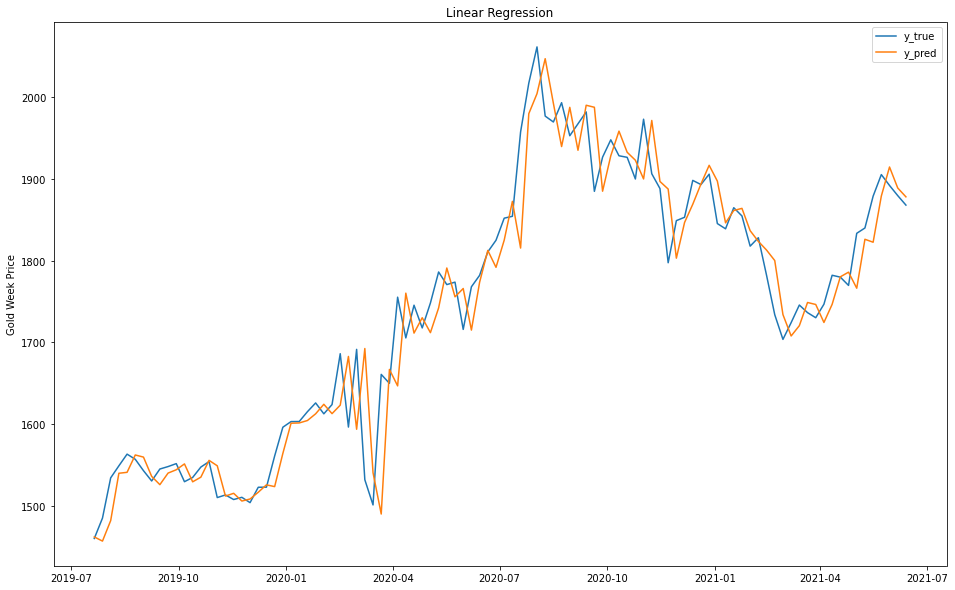

RMSE: 2081.002153214284


In [120]:
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['predicted_price'])
#predicted_price.head()
plot_graph(y_test, predicted_price, "Linear Regression")
#print(predicted_price)
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [121]:
df = pd.concat([y_test, predicted_price], axis=1)
df

,var1(t),predicted_price
Data,,
2019-07-21,1460.4,1462.251623
2019-07-28,1485.3,1457.187433
2019-08-04,1534.5,1482.222373
2019-08-11,1549.2,1540.113865
2019-08-18,1563.5,1541.260764
...,...,...
2021-05-16,1878.9,1822.591579
2021-05-23,1905.3,1879.016770
2021-05-30,1892.0,1914.578460


## Ridge

In [122]:
alpha_list = 10**(np.random.uniform(-3, 3, 50))
final_r2 = np.NINF
for alpha_value in alpha_list:
    ridge = Ridge(alpha=alpha_value).fit(X_train, y_train)
    predicted_price = ridge.predict(X_test)
    r2_score = ridge.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_alpha = alpha_value
#        final_coef0 = ridge.coef_[0]
#        final_coef1 = ridge.coef_[1]
#        final_coef2 = ridge.coef_[2]
#        final_coef3 = ridge.coef_[3]
#        final_intercept = ridge.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Melhor alpha = {}".format(final_alpha))
#print("Linear Regression model with Ridge (l2) regularization")
#print("Gold Week Price (y) = %.2f * Delta (x1) \
#+ %.2f * 3 Days Moving Average (x2) \
#+ %.2f * 9 Days Moving Average (x3) \
#+ %.2f * 35 Days Moving Average (x4) \
#+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.9163423781490646
Melhor alpha = 510.8722008599405


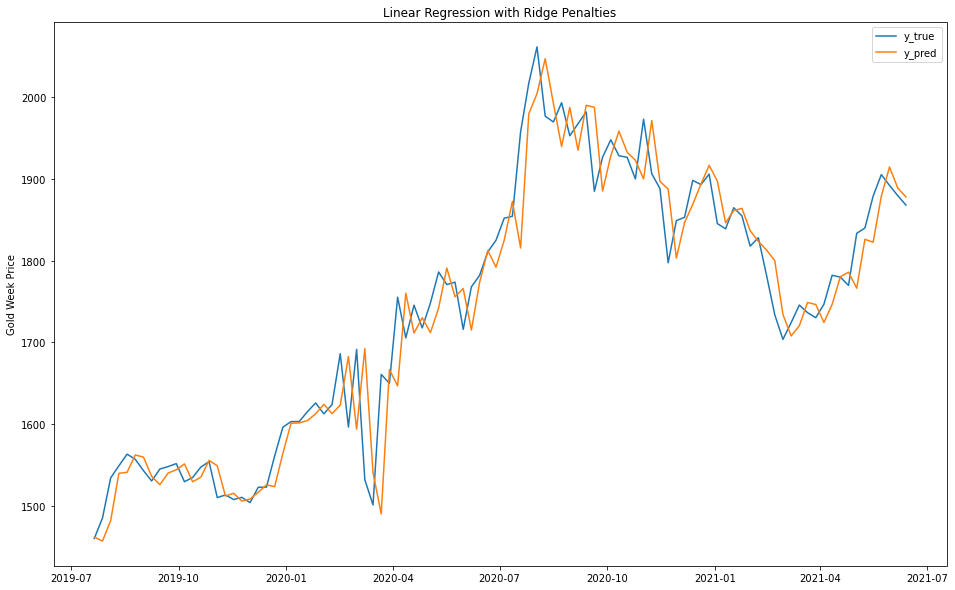

RMSE: 2079.5790620168013


In [123]:
ridge = Ridge(alpha=final_alpha).fit(X_train, y_train)
predicted_price = ridge.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['predicted_price'])
#predicted_price.head()
plot_graph(y_test, predicted_price, "Linear Regression with Ridge Penalties")
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

## Lasso

In [124]:
alpha_list = 10**(np.random.uniform(-3, 3, 50))
final_r2 = np.NINF
for alpha_value in alpha_list:
    lasso = Lasso(alpha=alpha_value, max_iter=10000).fit(X_train, y_train)
    predicted_price = lasso.predict(X_test)
    r2_score = lasso.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_alpha = alpha_value
#        final_coef0 = lasso.coef_[0]
#        final_coef1 = lasso.coef_[1]
#        final_coef2 = lasso.coef_[2]
#        final_coef3 = lasso.coef_[3]
#        final_intercept = lasso.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Melhor alpha = {}".format(final_alpha))
#print("Lasso (l1) regularization")
#print("Gold Week Price (y) = %.2f * Delta (x1) \
#+ %.2f * 3 Days Moving Average (x2) \
#+ %.2f * 9 Days Moving Average (x3) \
#+ %.2f * 35 Days Moving Average (x4) \
#+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.9230218189390509
Melhor alpha = 29.654672268548975


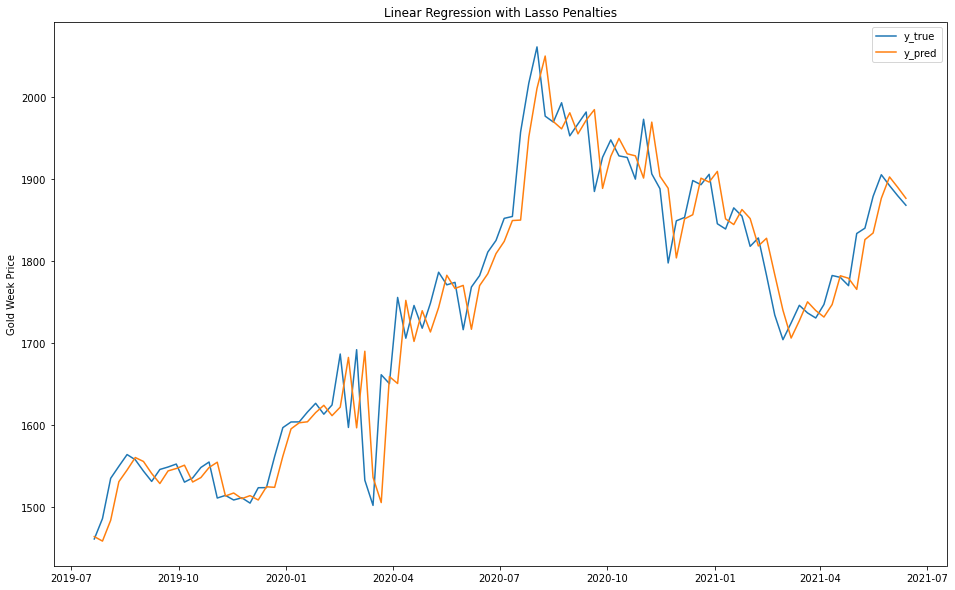

RMSE: 1913.540093833041


In [125]:
lasso = Lasso(alpha=final_alpha, max_iter=10000).fit(X_train, y_train)
predicted_price = lasso.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['predicted_price'])
#predicted_price.head()
plot_graph(y_test, predicted_price, "Linear Regression with Lasso Penalties")
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

## Random Forest Regressor

In [126]:
n_estimators_list = [10, 100, 1000]
final_r2 = np.NINF
for n_estimators_value in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n_estimators_value, max_features=5).fit(X_train, y_train)
    predicted_price = rf.predict(X_test)
    r2_score = rf.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_n_estimators = n_estimators_value    
print("Melhor R2 = {}".format(final_r2))
print("Valor de estimadores = {}".format(final_n_estimators))

Melhor R2 = 0.07035578605687065
Valor de estimadores = 10


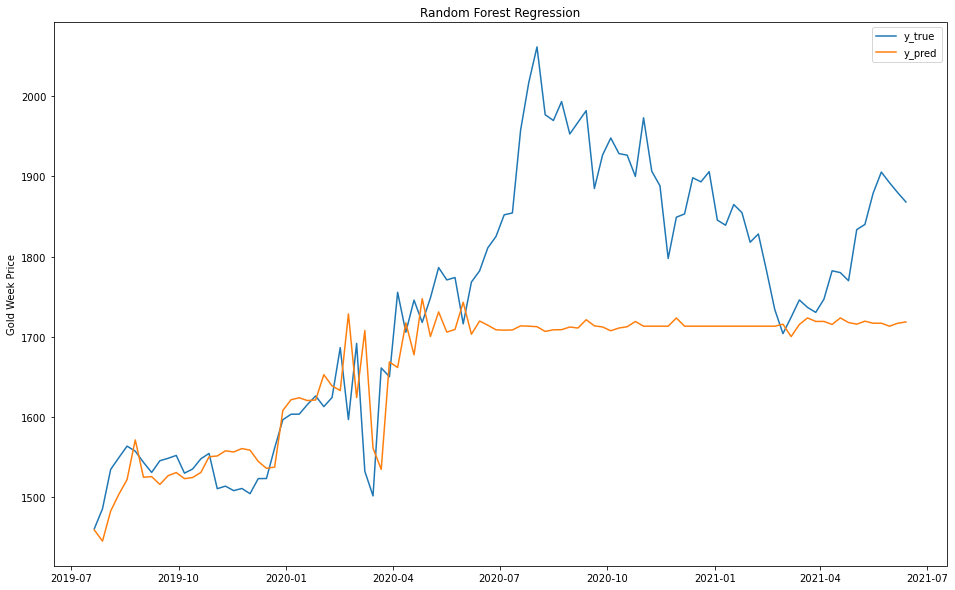

RMSE: 17223.758139000038


In [127]:
rf = RandomForestRegressor(n_estimators=final_n_estimators).fit(X_train, y_train)
predicted_price = rf.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['predicted_price'])
plot_graph(y_test, predicted_price, "Random Forest Regression")

rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

## Linear SVM Regressor

In [128]:
epsilon_list = [0.1, 0.3]
C_list = 2**(np.random.uniform(-5, 15, 10))
final_r2 = np.NINF
for C_value in C_list:
    epsilon_value = random.choice(epsilon_list)
    lsvmr = LinearSVR(epsilon = epsilon_value, C = C_value, max_iter = 10000).fit(X_train, y_train)
    predicted_price = lsvmr.predict(X_test)
    r2_score = lsvmr.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_epsilon = epsilon_value
        final_C = C_value

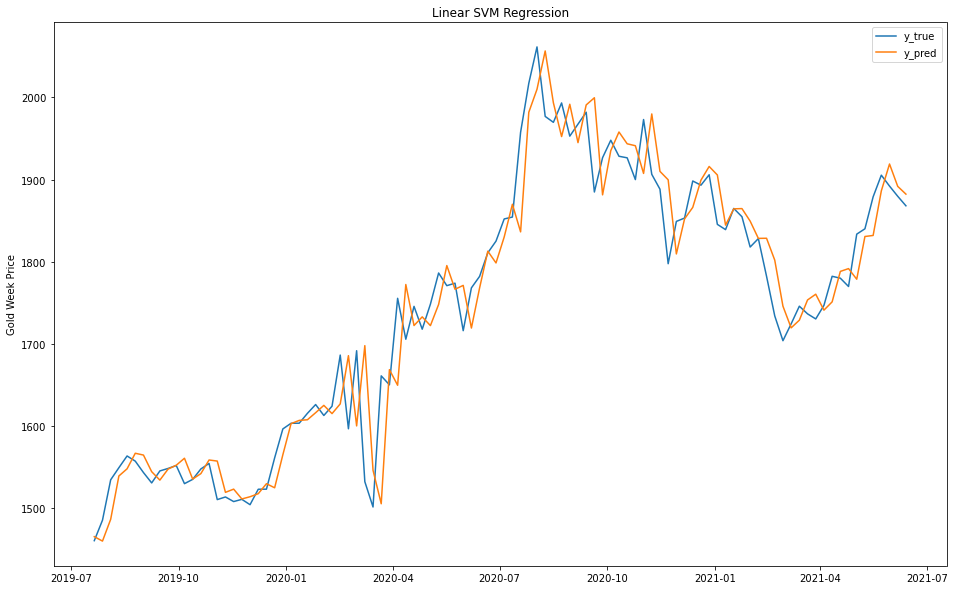

RMSE: 2045.196640109483


In [129]:
lsvmr = LinearSVR(epsilon = final_epsilon, C = final_C, max_iter = 10000).fit(X_train, y_train)
predicted_price = lsvmr.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['predicted_price'])
plot_graph(y_test, predicted_price, "Linear SVM Regression")
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

## RBF SVM Regressor

In [130]:
epsilon_list = [0.1, 0.3]
C_list = 2**(np.random.uniform(-5, 15, 10))
gamma_list = 2**(np.random.uniform(-9, 3, 10))
final_r2 = np.NINF
for C_value in C_list:
    epsilon_value = random.choice(epsilon_list)
    gamma_value = random.choice(gamma_list)
    svr = SVR(gamma = gamma_value, epsilon = epsilon_value, C = C_value, kernel='rbf').fit(X_train, y_train)
    predicted_price = svr.predict(X_test)
    r2_score = svr.score(X_test, y_test)    
    if r2_score > final_r2:
        final_r2 = r2_score
        final_epsilon = epsilon_value
        final_C = C_value
        final_gamma = gamma_value

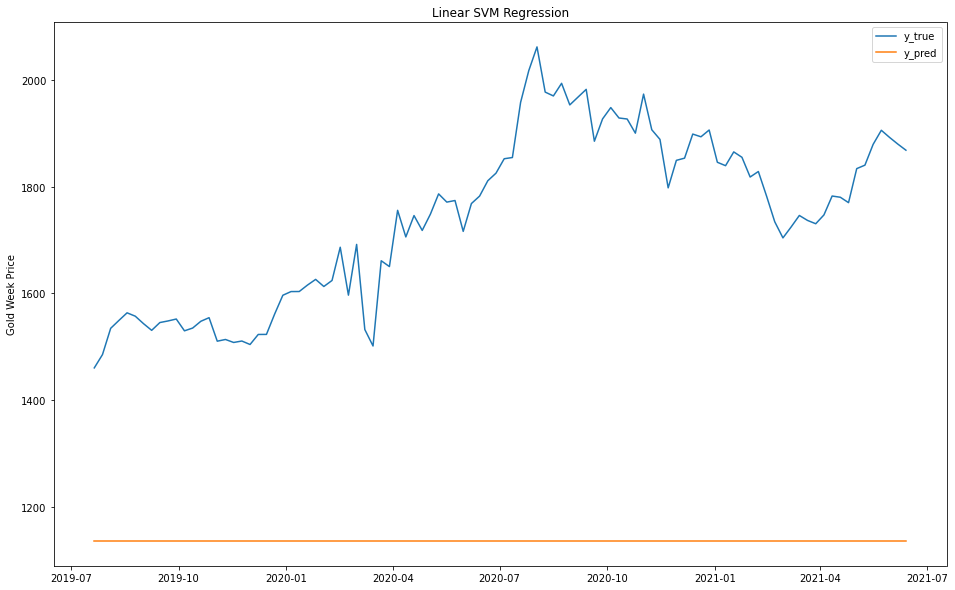

RMSE: 391265.6738000001


In [131]:
svr = SVR(gamma = final_gamma, epsilon = final_epsilon, C = final_C, kernel='rbf').fit(X_train, y_train)
predicted_price = svr.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['predicted_price'])
plot_graph(y_test, predicted_price, "Linear SVM Regression")
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)